## 演習問題

### 前提
Google Driveの`マイドライブ/Colab Notebooks`に`resource/yufuin_800_580.ppm`を入れておくこと

### Google Driveをマウント

In [ ]:
data_dir = '/drive/My Drive/Colab Notebooks/'

In [ ]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


### データ読み込み

In [ ]:
# ファイルを開いてデータ読み込み
#   binary read-onlyモードでファイルを開いて
with open(data_dir + 'yufuin_800_580.ppm', 'rb') as f:
    # データを読み込んでファイルを閉じる
    img_raw = f.read()

In [ ]:
# 読み込んだデータはbytes（バイナリデータ）となる
type(img_raw)

bytes

### 画像データの先頭（ヘッダの分析）

In [ ]:
# 先頭を覗いてみる
img_raw[:10]

b'P6\n# comme'

In [ ]:
# 改行文字で分離
img_split = img_raw.split(b'\n')
len(img_split)

2627

In [ ]:
# 先頭の方の4行を見てみる
img_split[0:4]

[b'P6', b'# comment', b'#', b'800 580']

In [ ]:
# b'P6'はbytes形式
type(img_split[0])

bytes

In [ ]:
# 文字列にするためにはdecodeする
type(b'P6'.decode())

str

### 画像サイズの抽出

In [ ]:
# P6は必ず先頭行
# その後のコメント行を読み飛ばす
line_no = 1
while True:
    # 念のため、改行文字などを除去
    target_line = img_split[line_no].decode().strip()
    if target_line[0] != '#':
        break
    line_no += 1

In [ ]:
# 画像サイズの行を抽出
img_size_str = img_split[line_no].decode().strip()
img_size_str

'800 580'

In [ ]:
# スペースで分離
img_size_str = img_size_str.split(' ')

In [ ]:
import numpy as np
if not all(np.char.isnumeric(img_size_str)):
    print('不正な画像ファイルです')
    quit()

In [ ]:
# 数値に変換
img_size = np.array(list(map(int, img_size_str)))
print("画像サイズ: {:d}x{:d}".format(img_size[0], img_size[1]))

画像サイズ: 800x580


## 発展問題
演習問題の続きから実行

### 画像の色階調数の抽出

In [ ]:
line_no += 1
img_depth_str = img_split[line_no].decode().strip()
if not np.char.isnumeric(img_depth_str):
    print('不正な画像ファイルです')
    quit()
img_depth = int(img_depth_str)
img_depth

255

In [ ]:
# PPM形式のimg_depthは必ず255のはず
if img_depth != 255:
    print('不正なPPM画像ファイルです')
    quit()

### 画像データ読み込み

In [ ]:
# RGBの3色それぞれが1 byteずつのデータとして格納されている
line_no += 1
img_data = b'\n'.join(img_split[line_no:])

In [ ]:
type(img_data)

bytes

In [ ]:
# 8-bitのunsigned intが並んでいるものとして画像データを読み込み
data = np.frombuffer(img_data, dtype=np.uint8)
data.shape

(1392000,)

In [ ]:
# データの長さは画像サイズから計算したものと同じになるはず
# 長さ = 画像横幅 * 画像縦幅 * 3色 * 1byte
img_size[0] * img_size[1] * 3 * 1

1392000

In [ ]:
# 先頭いくつかを見てみる
data[:10]

array([ 10,  97, 171,  14,  96, 173,  16,  96, 174,   9], dtype=uint8)

### 画像データの加工

In [ ]:
# R, G, Bの順に1 byteずつで明るさが並んでいるので並べ替えて3次元配列にする
# まず3色の順に並んでいるので3色に分け、
# 次に横軸に並んでいるので横軸の数で分け、
# 最後に縦軸の数で分ける
data = data.reshape(img_size[1], img_size[0], 3)
print(data.shape)

# 分かりやすくするため軸の順番を入れ替える
data = data.transpose(2,1,0)
print(data.shape)

(580, 800, 3)
(3, 800, 580)


In [ ]:
# x軸を逆順にすると左右反転できる
data_flipped = data[:,::-1,:]

In [ ]:
# heatmapで確認してみるためにRGBの平均をとる
m1 = np.mean(data, axis=0)
m2 = np.mean(data_flipped, axis=0)

In [ ]:
m1.shape, m2.shape

((800, 580), (800, 580))

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


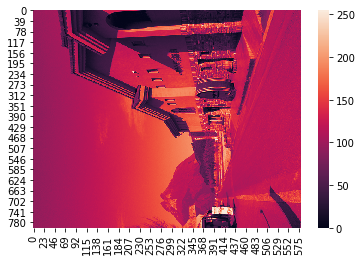

In [ ]:
# 元データ
sns.heatmap(m1)

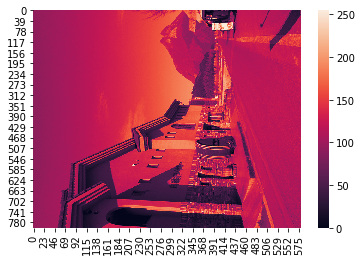

In [ ]:
# 反転後データ
sns.heatmap(m2)

### 画像の保存

In [ ]:
data_flipped.shape

(3, 800, 580)

In [ ]:
# 軸の順序を元に戻す
data_flipped = data_flipped.transpose(2,1,0)
data_flipped.shape

(580, 800, 3)

In [ ]:
outfile = 'yufuin_flip.ppm'
with open(data_dir + outfile, 'wb') as f:
    # ヘッダ情報は元画像と同じなのでそのまま出力
    f.write(b'\n'.join(img_split[:line_no]))
    f.write(b'\n')
    # 並べ替え済みのデータはそのまま保存
    f.write(data_flipped.tobytes())

ここまで実行すれば Google Driveの Colab Notebooks内に yufuin_flip.ppm が作成されるはず